# Study of the parameters

The objective of this study is to determine the influence of the comfort parameter $\alpha$, the thermal resistance $R_{th}$ and all the other parameters on the power distribution. For the simplicity of the preliminary approach, we will focus on the static model which is described in the study optim_static_cases.

One of the principal issue here is to get an overview of the compfort parameter in ordr to use it to cheat in the DMPC.


-- Sylvain Chatel, July 2016 --

In [1]:
from __future__ import division, print_function
import StaticOptimization as SO
from cvxopt import matrix, solvers
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
%matplotlib inline

/Users/sylvainchatel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Influence of the comfort parameter for a single user

To insure better comprehension to the reader, the comfort parameter is a ponderation coefficient which applies to each system to the quadratic difference between the temperature and the desired temperature.

$$ J(u) = J_{energy}(u) + \alpha J_{comfort}(u) $$

$$ J(u) = <\textbf{1}, u> + \sum_{i=1}^{n} \alpha(i)\; Rth_{i}\;(u_i-u_i^{ideal}) $$

###  Definition of the parameters

In [2]:
m = 1

# max energy in kW
Umax = 2
u_m = np.array([1.5], dtype=float)

# thermal resistance
Rth =np.array([10])

# Exterior temperature
Text = 10

# Ideal temperature in degrees
T_id = np.array([21], dtype=float)

# Ideal energy
deltaT = (T_id - Text)

# comfort factor
alpha = np.asarray([1], dtype=float)

pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)

### Influence of alpha on the energy and temperature

In [3]:
def param_alpha1(pb, a_beg, a_end, nbr):
    assert m==1, "illegal number of users. Expecting 1 and received %s." % m
    Rth=pb['Rth']
    Text=pb['Text']
    T_id=pb['T_id']
    Umax=pb['Umax']
    u_m=pb['u_m']
    alpha=pb['alpha']

    u_id = (T_id - Text) / Rth

    alpha_ratio = np.logspace(a_beg, a_end, nbr)

    _U = np.zeros( len(alpha_ratio))
    _DT = np.zeros(len(alpha_ratio))

    for z, ratio in enumerate(alpha_ratio):

        alpha_z = ratio*alpha
        _pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha_z)
        
        u_sol_d = SO.optim_central(_pb)[0]
        
        _U[z] = u_sol_d[0]
        _DT[z] = Rth[0] * (u_sol_d[0] - u_id[0])

    return _U, _DT, alpha_ratio

In [4]:
def plot_alpha1(_U, _DT, alpha_ratio):
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        ax1.plot(alpha_ratio, _U, 'r-+', label='1')

        ax1.hlines(Umax , alpha_ratio[0], alpha_ratio[-1], linestyles='--', label='')

        ax1.set(
            title=r'Parametric study of the comfort factor for $\alpha_=$ %s' % alpha[0],
            ylabel='$u^{*}$',
            xscale='log'
        )

        ax1.legend(loc='upper left', markerscale=0.4)

        ax2.plot(alpha_ratio, _DT, 'r')
    
        ax2.set(
            xlabel=r'$ \alpha*x$',
            ylabel=r'$\Delta T = T -T_{id}$',
        )

        fig.tight_layout()

        plt.show()

        return fig, (ax1, ax2)

In [5]:
_U, _DT, alpha_ratio = param_alpha1(pb, -3, 3, 50)

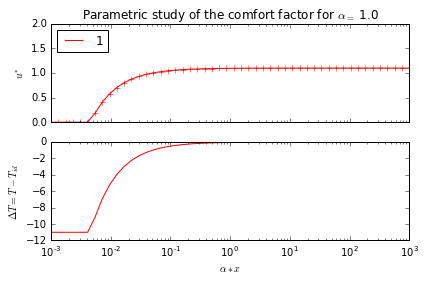

(<matplotlib.figure.Figure at 0x10a362350>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10a374990>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10ce21b50>))

In [6]:
plot_alpha1(_U, _DT, alpha_ratio)

On the previous figure, we can observe that below a threshold of $\alpha_{thr} \simeq \;0.003$, the system judges that it is not relevant to spend energy to satisfy the referenced temperature. Hence we must keep in mind that the comfort factor should always be superior to that threshold value so that comfort could be taken into account on the optimization problem.

## Influence of the comfort parameter for two users

### Definition of the parameters

In [7]:
# number of users
m = 2

# max energy in kW
Umax = 2
u_m = np.array([1.5, 1.5], dtype=float)

# thermal resistance
Rth =np.array([10, 10])

# Exterior temperature
Text = 10

# Ideal temperature in degrees
T_id = np.array([21, 21], dtype=float)

# Ideal energy
deltaT = (T_id - Text)

# comfort factor
alpha = np.asarray([1, 1], dtype=float)

pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)

### Study functions

In [8]:
def param_alpha2(pb, a_beg, a_end, nbr):
    assert m==2, "illegal number of users. Expecting 2 and received %s." % m
    Rth=pb['Rth']
    Text=pb['Text']
    T_id=pb['T_id']
    Umax=pb['Umax']
    u_m=pb['u_m']
    alpha=pb['alpha']

    u_id = (T_id - Text) / Rth

    alpha_ratio = np.logspace(a_beg, a_end, nbr)

    _U = np.zeros((2, len(alpha_ratio)))
    _DT = np.zeros((2, len(alpha_ratio)))

    for z, ratio in enumerate(alpha_ratio):

        alpha[1] = ratio*alpha[0]
        _pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)

        u_sol_d = SO.optim_central(_pb)[0]
    
        _U[0, z] = u_sol_d[0]
        _U[1, z] = u_sol_d[1]

        _DT[0,z] = Rth[0] * (u_sol_d[0] - u_id[0])
        _DT[1, z] = Rth[1] * (u_sol_d[1] - u_id[1])

    return _U, _DT, alpha_ratio


def plot_alpha2(_U, _DT, alpha_ratio):

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        ax1.plot(alpha_ratio, _U[0, :], 'r-+', label='1')
        ax1.plot(alpha_ratio, _U[1, :], 'g-+', label='2')

        ax1.hlines(Umax , alpha_ratio[0], alpha_ratio[-1], linestyles='--', label='')

        ax1.set(
            title=r'Parametric study of the comfort factor for $\alpha_1=$ %s' % alpha[0],
            xlabel=r'$ \alpha_{2} / \alpha_{1} $',
            ylabel='$u^{*}$',
            xscale='log'
        )

        ax1.legend(loc='upper left', markerscale=0.4)

        ax2.plot(alpha_ratio, _DT[0, :], 'r')
        ax2.plot(alpha_ratio, _DT[1, :], 'g')

        ax2.set(
            xlabel=r'$ \alpha_{2} / \alpha_{1} $',
            ylabel=r'$\Delta T = T -T_{id}$',
        )

        fig.tight_layout()

        plt.show()

        return fig, (ax1, ax2)

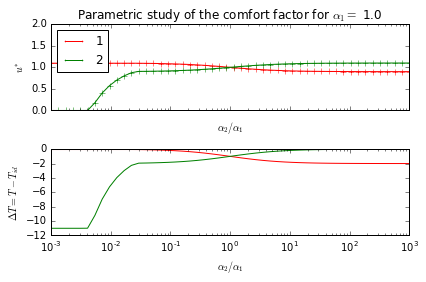

(<matplotlib.figure.Figure at 0x10ce5bd10>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10d002d50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10ff11ed0>))

In [9]:
_U, _DT, alpha_ratio = param_alpha2(pb, -3, 3, 50)
plot_alpha2(_U, _DT, alpha_ratio)

On the prvious figure, we can observe that the influence of $\alpha$. The more $\alpha$ is superior from the others, the more the user will get a satisfactory energy to reach the reference temperature. Putting aside the influence of the consumption (between 0 and 0.003) we notice as well that the problem is symetrical.

## Influence of the comfort parameter for multiple users

In this section we aim to explain the influence of different value of the comfort parameter on the optimization solution. We consider five users, all identical. 

### Definition of the parameters

In [10]:
# number of users
m = 5
i = np.arange(m)

# max energy in kW
Umax = 2
u_m = np.array([1.5, 1.5, 1.5, 1.5, 1.5], dtype=float)

# thermal resistance
Rth =np.array([10, 10, 10, 10, 10])

# Exterior temperature
Text = 10

# Ideal temperature in degrees
T_id = np.array([21, 21, 21, 21, 21], dtype=float)

# Ideal energy
deltaT = (T_id - Text)

# comfort factor
alpha = np.asarray([2, 2, 2, 2, 2], dtype=float)

pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)

### Creation of the study functions

In [11]:
def param_alpha(pb, a_beg, a_end, nbr):
    Rth=pb['Rth']
    Text=pb['Text']
    T_id=pb['T_id']
    u_m=pb['u_m']
    alpha=pb['alpha']
    Umax = pb['Umax']
    u_id = (T_id - Text) / Rth

    alpha_ratio = np.logspace(a_beg, a_end, nbr)

    _U = np.zeros((m, len(alpha_ratio)))
    _DT = np.zeros((m, len(alpha_ratio)))

    for z, ratio in enumerate(alpha_ratio):

        alpha[m-1] = ratio*alpha[0]
        _pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)
        
        u_sol_d = SO.optim_central(_pb)[0]
        
        for k in range(m):
            _U[k, z] = u_sol_d[k]
            _DT[k, z] = Rth[k] * (u_sol_d[k] - u_id[k])

    return _U, _DT, alpha_ratio


In [12]:
def plot_alpha(_U, _DT, alpha_ratio):
        Umax = pb['Umax']
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        for k in range(m-1):
            ax1.plot(alpha_ratio, _U[k, :], 'g')
        ax1.plot(alpha_ratio, _U[m-1, :], 'r')

        ax1.hlines(Umax/m , alpha_ratio[0], alpha_ratio[-1], linestyles='--', label='')

        ax1.set(
            title=r'Parametric study of the comfort factor for $\alpha=$ %s and Umax = %s.' % (alpha[0],Umax),
            xlabel=r'$ \alpha_{%s} / \alpha_{1} $'% m,
            ylabel='$u^{*}$',
            xscale='log'
        )
        for k in range(m-1):
            ax2.plot(alpha_ratio, _DT[k, :], 'g')
        ax2.plot(alpha_ratio, _DT[m-1, :], 'r')
        
        ax2.set(
            xlabel=r'$ \alpha_{%s} / \alpha_{1} $' % m,
            ylabel=r'$\Delta T = T -T_{id}$',
        )

        fig.tight_layout()

        plt.show()

        return fig, (ax1, ax2)

In [13]:
_U, _DT, alpha_ratio = param_alpha(pb, -3, 3, 50)

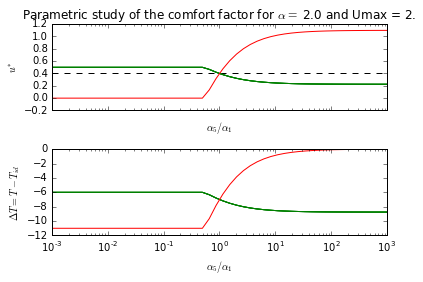

(<matplotlib.figure.Figure at 0x10ff7e090>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10feaae90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1103a2d50>))

In [14]:
plot_alpha(_U, _DT, alpha_ratio)

In [15]:
pb['Umax'] = 10
_U, _DT, alpha_ratio = param_alpha(pb, -3, 3, 50)

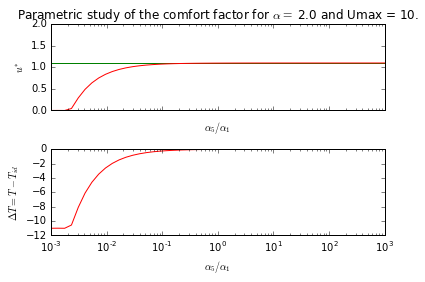

(<matplotlib.figure.Figure at 0x10d545c10>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1118aea90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x111945190>))

In [16]:
plot_alpha(_U, _DT, alpha_ratio)

### Influence of the broadcasted temperature

In [17]:
m = 3
# max energy in kW
Umax = 5
u_m = np.array([1.5, 1.5, 1.5], dtype=float)
# thermal resistance
Rth =np.array([10, 10, 10])
# Exterior temperature
Text = 10
# Ideal temperature in degrees
T_id = np.array([21, 21, 21], dtype=float)
# Ideal energy
deltaT = (T_id - Text)
# comfort factor
alpha = np.asarray([10, 10, 10], dtype=float)
pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)

In [18]:
def param_Tbc(pb):
    assert m == 3, "illegal number of users. Expecting 3 and received %s." % m
    Rth = pb['Rth']
    Text = pb['Text']
    T_id = pb['T_id']
    Umax = pb['Umax']
    u_m = pb['u_m']
    alpha = pb['alpha']
    T_id_cht = T_id.copy()

    u_id_real = (T_id - Text) / Rth

    T_sup = np.linspace(-4, 4, 20)

    _U = np.zeros((3, len(T_sup)))
    _DT = np.zeros((3, len(T_sup)))

    for z, sup in enumerate(T_sup):

        T_id_cht[0] = T_id[0] + sup

        _pb = dict(Rth=Rth, Text=Text, T_id=T_id_cht, Umax=Umax, u_m=u_m, alpha=alpha)

        u_sol_d = SO.optim_central(_pb)[0]
        _U[0, z] = u_sol_d[0]
        _U[1, z] = u_sol_d[1]
        _U[2, z] = u_sol_d[2]
        _DT[0, z] = Rth[0] * (u_sol_d[0] - u_id_real[0])
        _DT[1, z] = Rth[1] * (u_sol_d[1] - u_id_real[1])
        _DT[2, z] = Rth[2] * (u_sol_d[2] - u_id_real[2])

    return _U, _DT, T_sup


def plot_Tbc(_U, _DT, T_sup):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(T_sup, _U[0, :], 'r-+', label='1')
    ax1.plot(T_sup, _U[1, :], 'g-+', label='2')
    ax1.plot(T_sup, _U[2, :], 'g-+', label='3')

    ax1.hlines(Umax, T_sup[0], T_sup[-1], linestyles='--', label='')

    ax1.set(
        title=r'Parametric study of the comfort factor for $\alpha_1=$ %s' % alpha[0],
        xlabel=r'$ T_{sup} $',
        ylabel='$u^{*}$',
        #xscale='log',
    )

    ax1.legend(loc='upper left', markerscale=0.4)

    ax2.plot(T_sup, _DT[0, :], 'r')
    ax2.plot(T_sup, _DT[1, :], 'g')
    ax2.plot(T_sup, _DT[2, :], 'b')
    ax2.plot(T_sup, T_sup,'--')

    ax2.set(
        xlabel=r'$ T_{sup} $',
        ylabel=r'$\Delta T = T -T_{id}$',
    )

    fig.tight_layout()

    plt.show()

    return fig, (ax1, ax2)

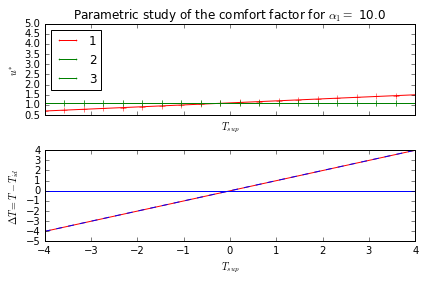

(<matplotlib.figure.Figure at 0x1118ea610>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x111fc80d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x111d28150>))

In [19]:
 _U, _DT, ratio_Tbc = param_Tbc(pb)
plot_Tbc(_U, _DT, ratio_Tbc)

### Influence of the broadcasted Rth

In [20]:
m = 3
# max energy in kW
Umax = 2
u_m = np.array([1.5, 1.5, 1.5], dtype=float)
# thermal resistance
Rth =np.array([10, 10, 10], dtype=float)
# Exterior temperature
Text = 10.
# Ideal temperature in degrees
T_id = np.array([21, 21, 21], dtype=float)
# Ideal energy
deltaT = (T_id - Text)
# comfort factor
alpha = np.asarray([10, 10, 10], dtype=float)
pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)

In [21]:
def param_Rth(pb):
    assert m == 3, "illegal number of users. Expecting 3 and received %s." % m
    Rth = pb['Rth']
    Rth_cht = pb['Rth'].copy()
    Text = pb['Text']
    T_id = pb['T_id']
    Umax = pb['Umax']
    u_m = pb['u_m']
    alpha = pb['alpha']
    
    u_id = (T_id - Text)*1.0 / Rth

    varRth = np.linspace(1.0, 40.0, 100)

    _U = np.zeros((3, len(varRth)))
    _DT = np.zeros((3, len(varRth)))

    for z, sup in enumerate(varRth):

        Rth_cht[0] = sup

        _pb = dict(Rth=Rth_cht, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)

        u_sol_d = SO.optim_central(_pb)[0]
        _U[0, z] = u_sol_d[0]
        _U[1, z] = u_sol_d[1]
        _U[2, z] = u_sol_d[2]
        _DT[0, z] = Rth[0] * (u_sol_d[0] - u_id[0])
        _DT[1, z] = Rth[1] * (u_sol_d[1] - u_id[1])
        _DT[2, z] = Rth[2] * (u_sol_d[2] - u_id[2])

    return _U, _DT, varRth, Rth


def plot_Rth(_U, _DT, varRth, Rth):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(varRth, _U[0, :], 'r', label='1')
    ax1.plot(varRth, _U[1, :], 'g', label='2')
    ax1.plot(varRth, _U[2, :], 'g--', label='3')

    ax1.hlines(Umax, varRth[0], varRth[-1], linestyles='--', label='')

    ax1.set(
        title=r'Parametric study of the broacasted Rth for $Rth_{real}$= %s' % Rth[0],
        xlabel=r'$ T_{sup} $',
        ylabel='$u^{*}$',
        #xscale='log',
    )

    ax1.legend(loc='upper left', markerscale=0.4)

    ax2.plot(varRth, _DT[0, :], 'r')
    ax2.plot(varRth, _DT[1, :], 'g')
    ax2.plot(varRth, _DT[2, :], 'b--')

    ax2.set(
        xlabel=r'$Rth$',
        ylabel=r'$\Delta T = T -T_{id}$',
    )

    fig.tight_layout()

    plt.show()

    return fig, (ax1, ax2)

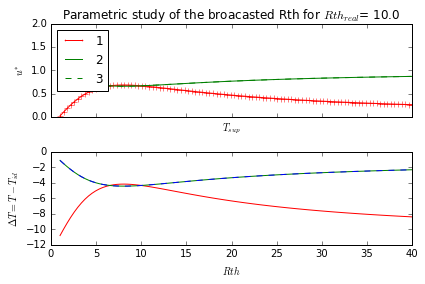

(<matplotlib.figure.Figure at 0x11038d250>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10ff28890>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11247ce50>))

In [22]:
_U, _DT, ratio_Rth, Rth= param_Rth(pb)
plot_Rth(_U, _DT, ratio_Rth, Rth)

## Conclusion

Through this study, we were able do stermine the inluence of the different parameters on the energy distribution in the static case. Those results will be useful to determine cheating strategies for the DMPC. In a near future we ought to study the influence of the above parameters in a dynamic model.